Рассчитать с машинной точностью интеграл с неопределенностью 
$$
    \int\limits_{-1}^1 \frac{\sin(x/2)}{e^x-1} dx
$$
 квадратурой на разностных схемах.

In [5]:
from decimal import Decimal, getcontext
import math
from functools import lru_cache

###############################################################################
#  1) Вспомогательные функции для разностных квадратур                        #
###############################################################################
getcontext().prec = 100  # повышенная точность для Decimal

@lru_cache(None)
def factorial_dec(n: int) -> Decimal:
    if n < 0:
        raise ValueError("Negative factorial not defined")
    if n == 0 or n == 1:
        return Decimal(1)
    return Decimal(n) * factorial_dec(n - 1)

@lru_cache(None)
def comb_dec(n: int, k: int) -> Decimal:
    if k < 0 or k > n:
        return Decimal(0)
    return factorial_dec(n) / (factorial_dec(k) * factorial_dec(n - k))

@lru_cache(None)
def D(n: int, j: int) -> Decimal:
    """
    Вычисляет D_n^(j) по заданной рекуррентной формуле (см. теорию).
    """
    if j == 0:
        return Decimal(1)
    # "прогреваем" кэш:
    _ = D(n, j-1)
    return _compute_all_D_up_to(n, j)[j]

@lru_cache(None)
def _compute_all_D_up_to(n: int, J: int):
    results = [Decimal(0)]*(J+1)
    results[0] = Decimal(1)
    for j in range(J):
        s = Decimal(0)
        for k in range(n + 2*j + 1):
            for l in range(j+1):
                val = (
                    Decimal((-1)**k)
                    * results[l]
                    * comb_dec(n+2*l, k - (j - l))
                    * Decimal((n + 2*j - 2*k)**(n + 2*j + 2))
                    / (Decimal(2)**(n + 2*j + 2) * factorial_dec(n + 2*j + 2))
                )
                s += val
        # Финальная формула берёт только s, без + results[j].
        results[j+1] = s
    return results

@lru_cache(None)
def A(k: int, n: int, m: int) -> Decimal:
    """
    A_{k,n}^m = sum_{l=0}^m [ (-1)^(k-m) * D_n^(l) * C_{n+2l}^{k - m + l} ].
    """
    s = Decimal(0)
    sign = Decimal((-1)**(k - m))
    for l in range(m+1):
        s += (
            sign
            * D(n, l)
            * comb_dec(n+2*l, k - m + l)
        )
    return s

@lru_cache(None)
def W_list(m: int):
    """
    Коэффициенты W_k^m (k=0..2m) в Decimal.

      W_k^m = sum_{n=0}^m [ A_{k,2n}^{m-n} / (2^(2n)*(2n+1)!) ].
    """
    result = []
    for k in range(2*m + 1):
        s = Decimal(0)
        for n_ in range(m+1):
            a_val = A(k, 2*n_, m - n_)
            denom = (Decimal(2)**(2*n_) * factorial_dec(2*n_+1))
            s += a_val / denom
        result.append(s)
    return result

def build_function_values_diff_scheme(f, a: float, b: float, J: int, m: int):
    """
    Центральная сетка: x_j = a + (j+0.5)*h, j=-m..(J-1+m).
    Возвращает (y_values, h, calls).
    """
    h = (b - a)/J
    values = []
    for j_real in range(-m, (J - 1) + m + 1):
        x_val = a + (j_real + 0.5)*h
        values.append(f(x_val))
    calls = len(values)
    return values, h, calls

def integrate_by_diff_scheme(f, a: float, b: float, J: int, m: int):
    """
    Разностная (дифференсная) квадратура порядка 2m:
      ∫[a..b] f(x) dx ≈ h Σ_j Σ_k [ W_{m-k} * f( x_{j+k} ) ].
    Возвращает (approx, calls).
    """
    y_values, h, calls = build_function_values_diff_scheme(f, a, b, J, m)
    W_dec = W_list(m)
    W = [float(wd) for wd in W_dec]
    
    offset = m
    total_sum = 0.0
    for j in range(J):
        loc_sum = 0.0
        for k in range(-m, m+1):
            idx = (j + k) + offset
            loc_sum += W[m - k] * y_values[idx]
        total_sum += loc_sum
    return (h * total_sum, calls)

In [ ]:
def f1(x):
  return np.sin(x/2)/(np.exp(x)-1)

exact_val_1 = 1.01303923623262610131 # Из вольфрама с запасом (машиной считаются только первые 16 цифр)

In [ ]:
diff_approx, diff_calls = integrate_by_diff_scheme(f1, -1, 1, 8, 3)
diff_err = abs(diff_approx - exact_val_1)
for m in [3, 4, 5, 6, 7, 9]:
    print(f"--- m={m} ---")
    for J in [2, 4, 8, 16, 24]:
        diff_approx, diff_calls = integrate_by_diff_scheme(f1, -1, 1, J, m)
        diff_err = abs(diff_approx - exact_val_1)

        print(f" J={J}, calls={diff_calls:2d} | "
                f"DiffScheme={diff_approx:.8f}, err={diff_err:.2e} | ")
    print()

--- m=3 ---
 J=2, calls= 8 | DiffScheme=1.01303490, err=4.34e-06 | 
 J=4, calls=10 | DiffScheme=1.01303922, err=1.96e-08 | 
 J=8, calls=14 | DiffScheme=1.01303924, err=7.95e-11 | 
 J=16, calls=22 | DiffScheme=1.01303924, err=3.14e-13 | 
 J=24, calls=30 | DiffScheme=1.01303924, err=1.22e-14 | 

--- m=4 ---
 J=2, calls=10 | DiffScheme=1.01303816, err=1.07e-06 | 
 J=4, calls=12 | DiffScheme=1.01303923, err=1.45e-09 | 
 J=8, calls=16 | DiffScheme=1.01303924, err=1.54e-12 | 
 J=16, calls=24 | DiffScheme=1.01303924, err=1.33e-15 | 
 J=24, calls=32 | DiffScheme=1.01303924, err=2.22e-16 | 

--- m=5 ---
 J=2, calls=12 | DiffScheme=1.01303887, err=3.65e-07 | 
 J=4, calls=14 | DiffScheme=1.01303924, err=1.58e-10 | 
 J=8, calls=18 | DiffScheme=1.01303924, err=4.49e-14 | 
 J=16, calls=26 | DiffScheme=1.01303924, err=2.22e-16 | 
 J=24, calls=34 | DiffScheme=1.01303924, err=0.00e+00 | 

--- m=6 ---
 J=2, calls=14 | DiffScheme=1.01303908, err=1.54e-07 | 
 J=4, calls=16 | DiffScheme=1.01303924, err=2.2

# Задача 2.
Используя методику прямой сшивки при взятии сумм рядов, рассчитать постоянную $\gamma_E$ Эйлера-Маскерони с ошибкой в 13 знаке по формуле
$$
    \gamma_E = \lim\limits_{n \rightarrow \infty} \left( 1 + \frac{1}{2} + ... \frac{1}{n} - \ln n \right).
$$

По теорме о быстром вычислении большой суммы плавной последовательности
$$
    \gamma_E^n = \sum\limits_{j = 0}^{n-1} \frac{1}{j+1} - \ln n = \int\limits_{j_m + 1/2}^{n - 1/2} \frac{dj}{j+1} + \sum\limits_{j = 0}^{j_m -m} \frac{1}{j+1} - \sum\limits_{j = n}^{n + m - 1} \frac{1}{j+1} + \sum\limits_{j = j_m - m + 1}^{j_m + m} (1 - I_{j + m - j_m - 1}^m) \frac{1}{j+1} + \sum\limits_{j = n-m}^{n+m-1} I_{j+m-n}^m \frac{1}{j+1} - \ln n + O(1 / j_s^{2m + 2}) =
$$
$$
    = \ln \left(\frac{n+1/2}{n} \right) - \ln(j_m + 3/2) + \sum\limits_{j = 1}^{j_m -m + 1} \frac{1}{j} - \sum\limits_{j = n + 1}^{n + m} \frac{1}{j} + \sum\limits_{j = j_m - m + 2}^{j_m + m + 1} (1 - I_{j + m - j_m - 2}^m) \frac{1}{j} + \sum\limits_{j = n-m + 1}^{n+m} I_{j+m-n - 1}^m \frac{1}{j} + O(1 / j_s^{2m + 2}).
$$

Что при $n \rightarrow \infty$ равно
$$
    \gamma_E = - \ln(j_m + 3/2) + \sum\limits_{j = 1}^{j_m -m + 1} \frac{1}{j} + \sum\limits_{j = j_m - m + 2}^{j_m + m + 1} (1 - I_{j + m - j_m - 2}^m) \frac{1}{j} + O(1 / j_s^{2m + 2}).
$$

Здесь $m = 7$ -- задает точность вычисления, $j_m$ -- количество членов, которые мы готовы суммировать, после начинается переход к интеграллу, $j_s$ задается условием:
$$
    \text{Пусть $\varepsilon$ -- точность, тогда } \forall j \geq j_m \text{ должно существовать } j_s: \forall i \in [j, j+j_s] \rightarrow |\frac{a_i}{a_j} - 1| < \varepsilon \Leftrightarrow j_s < \frac{\varepsilon}{1 - \varepsilon} \cdot j_m \Rightarrow j_m \gg j_s.
$$

По условию нужно, чтобы $1 / j_s^{2m + 2} \ll 10^{-13}$. Тогда, если $m = 7$, получим $j_s \gg 7$. Получаем $j_m \gg 7$, ну там $j_m = 100000$.

In [ ]:
def I(m: int, l: int):
    W = W_list(m)
    result = 0
    for k in range(l+1):
        result += W[2*m - k]
    return result

In [32]:
import numpy as np

In [36]:
j_m = 100000
m=7

sum1 = 0
for j in range(1, j_m-m+1 + 1):
    sum1 += 1. / j


sum2 = 0
for j in range(j_m-m+2, j_m+m+1 + 1):
    sum2 += float(1 - I(m, j+m-j_m-2)) / float(j)

print("gamma_E =", -np.log(j_m+3/2) + sum1 + sum2, ", error =", -np.log(j_m+3/2) + sum1 + sum2 - 0.57721566490153286060651209008240243104215933593992359880576723488486772677766467093694706329174674951463144724 )

gamma_E = 0.5772156649014419 , error = -9.092726571680032e-14


# Задача 3.
Вычислить сумму ряда
$$
S = \sum\limits_{n=1}^\infty \frac{n^2+1}{n^4+n^2+1} \cos(2n)
$$
с точностью $\varepsilon = 10^{-6}$, применяя метод Куммера.

Решение буквально написано на сайте. Т.к. остаток этого ряда можно оценить как
$$
    |r_k| = |\sum\limits_{n=k+1}^\infty \frac{n^2+1}{n^4+n^2+1} \cos(2n) | < \sum\limits_{n=k+1}^\infty \frac{n^2+1}{n^4+n^2} < \sum\limits_{n=k+1}^\infty \frac{1}{n^2} < \int\limits_{k+1}^\infty \frac{dx}{x^2} = \frac{1}{k+1} < \varepsilon = 10^{-6}.
$$
То необходимое число операции $k > 10^6$, что слишком много.

Воспользуемся методом Куммера. Используя то, что
$$
    S' = \sum\limits_{n=1}^\infty \frac{\cos(nx)}{n^2} = \frac{\pi^2}{6} - \frac{\pi x}{12} + \frac{x^2}{4}
$$
при $x=2$.

Тогда $\gamma = \lim\limits_{n \rightarrow \infty} \frac{a_n}{a_n'} = 1$.

Представим ряд как
$$
    S = \gamma S' + \sum\limits_{n=0}^\infty (a_n - \gamma a_n')= \frac{\pi^2}{6} - \frac{\pi}{6} + 1 + \sum\limits_{n=1}^\infty \left( \frac{n^2+1}{n^4+n^2+1} - \frac{1}{n^2} \right) \cos(2n) = \frac{\pi^2}{6} - \frac{\pi}{6} + 1 + \sum\limits_{n=1}^\infty \frac{\cos(2n)}{n^2(n^4+n^2+1)}.
$$

Остаток ряда можно аналогично оценить как
$$
    |r_k'| < \frac{1}{5(k+1)^5} < \varepsilon = 10^{-6}.
$$
Получаем необходимо $k \geq 12$.

In [28]:
sum = np.pi ** 2 / 6 - np.pi / 6 + 1
for n in range(1, 15):
    sum += np.cos(2*n) / (n**2 * (n**4 + n**2 + 1))

sum

1.975942055783409

# Задача 4.  
Взять предел
$$
    \lim_{x \rightarrow 0} \frac{y(x) - 1}{x},
$$
где $y(x) = \ch \sqrt{x}$, если $x>0$, $y(x) = \cos \sqrt{-x}$, если $x<0$.

 
  
Поиграться с выбором шага.

Будем использовать формулу вычисления предела четной функции в нуле.

Четность будем добиваться убиранием корневой особенности
$$
    \lim\limits_{x \rightarrow 0} \frac{y(x) - 1}{x} = \lim\limits_{\xi \rightarrow 0} \frac{y(\xi^2) - 1}{\xi^2} = \lim\limits_{\xi \rightarrow 0} \frac{\ch \sqrt{\xi^2} - 1}{\xi^2}
$$

In [ ]:
def y(x):
    return np.cosh(x**0.5) if x > 0 else np.cos((-x)**0.5)

def der_y(xi):
    return (y(xi**2) - 1) / xi**2

In [21]:
def Limit_in_zero(func, Delta_x:float, m:int, N: int):
    result = 0
    for n in range(N+1):
        for k in range(2*m + n%2):
            y = func(Delta_x * (1/2 + 2*m + n%2 - 2*k))
            result += float(A(k, n, m - (n - n%2)//2)) * ( (-1)**n / (4**n * math.factorial(n)) ) * y
    
    return result

In [35]:
def f(x):
    return np.sin(x) * np.e / x

In [45]:
Limit_in_zero(der_y, 1e-4, 9, 18)

0.4999999961177398

In [50]:
import matplotlib.pyplot as plt

Text(0, 0.5, '|result - 0.5|')

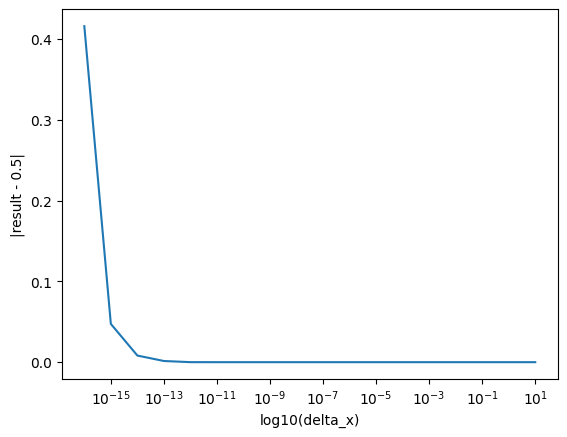

In [62]:
DELTA_X = np.logspace(-16, 1, 18)

ERROR_OF_RESULT = []
for delta_x in DELTA_X:
    ERROR_OF_RESULT.append(np.abs(Limit_in_zero(der_y, delta_x, 9, 18) - 0.5))

plt.plot(DELTA_X, ERROR_OF_RESULT)
plt.xscale('log')
plt.xlabel("log10(delta_x)")
plt.ylabel("|result - 0.5|")

Text(0, 0.5, '|result - 0.5|')

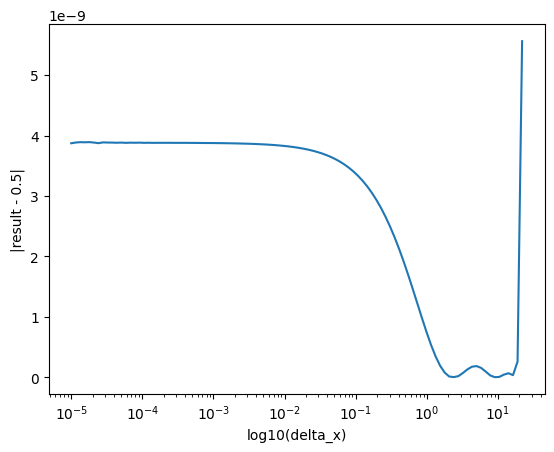

In [70]:
DELTA_X = np.logspace(-5, 1.34, 100)

ERROR_OF_RESULT = []
for delta_x in DELTA_X:
    ERROR_OF_RESULT.append(np.abs(Limit_in_zero(der_y, delta_x, 9, 18) - 0.5))

plt.plot(DELTA_X, ERROR_OF_RESULT)
plt.xscale('log')
plt.xlabel("log10(delta_x)")
plt.ylabel("|result - 0.5|")